<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install joblib
import tensorflow as tf 
import pickle
from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math

from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#FEATURES AND LABELS  


with open('/content/features_withITO (2).bin','rb') as file:
  features = pickle.load(file)
  
  
with open('/content/labels_withITO (2).bin','rb') as file:
  labels = pickle.load(file)

In [0]:

temp =[]
for i in features:
  temp.append(list(i))

l=[]  
for i in labels:
  l.append(list(i))

In [21]:
print(temp)

[[0.8333333, 0.0, 0.0004570959, 0.32954547, 0.4988864, 0.7058824, 0.07777778, 0.54545456, 0.23706636], [0.8333333, 0.6585629, 0.6957576, 0.32954547, 0.4988864, 0.7058824, 0.07777778, 0.54545456, 0.22494265], [0.8333333, 0.6700596, 0.7311326, 0.32954547, 0.4988864, 0.7352941, 0.04074074, 0.45454547, 0.317222], [0.8333333, 2.7558504e-05, 0.0, 0.32954547, 0.4988864, 0.7352941, 0.04074074, 0.45454547, 0.25359133], [0.8333333, 0.6856352, 0.73653024, 0.32954547, 0.4988864, 0.7352941, 0.04074074, 0.45454547, 0.32882836], [0.8333333, 0.62684774, 0.791602, 0.32954547, 0.4988864, 0.7352941, 0.04074074, 0.45454547, 0.28207588], [0.9166667, 0.6981077, 0.6585211, 0.32954547, 0.4988864, 0.7352941, 0.04074074, 0.45454547, 0.2591012], [0.9166667, 0.7100977, 0.7461016, 0.32954547, 0.4988864, 0.7352941, 0.04074074, 0.45454547, 0.3099037], [0.9166667, 0.71096635, 0.74690676, 0.32954547, 0.4988864, 0.7352941, 0.04074074, 0.45454547, 0.30985114], [0.9166667, 0.7295016, 0.75013846, 0.32954547, 0.4988864, 0.

In [22]:
print(l)

[[47.0], [47.0], [47.0], [47.0], [47.0], [47.0], [45.0], [45.0], [45.0], [45.0], [45.0], [45.0], [45.0], [45.0], [45.0], [45.0], [45.0], [45.0], [45.0], [45.0], [45.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [36.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [180.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [190.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [92.0], [45.0]

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
## 56 BIT (2253,3147)

# features = joblib.load('/content/features56.pkl')
# labels = joblib.load('/content/labels56.pkl')


In [0]:
## 64 BIT (2253,3147)

# features = joblib.load('/content/features64.pkl')
# labels = joblib.load('/content/labels64.pkl')


In [0]:
# # 32 BIT (2253,1035)

# features = joblib.load('/content/features32.pkl')
# labels = joblib.load('/content/labels32.pkl')

In [9]:
# print(features[0])
# print(len(features[0]))
# print(len(features))


print(np.shape(temp))
print(np.shape(labels))


#features = features.astype(float)
 

(2376, 9)
(2376, 1)


In [26]:
# show = np.ndarray.flatten(f)


# print(features[0])
print(labels[0])

[8.3333331e-01 0.0000000e+00 4.5709591e-04 3.2954547e-01 4.9888641e-01
 7.0588237e-01 7.7777781e-02 5.4545456e-01 2.3706636e-01]
[47.]


In [23]:
print(x_train_t)


[[0.58333333 0.79939315 0.83913781 ... 0.97196262 1.         1.        ]
 [0.83333333 0.88442312 0.71455091 ... 0.98431373 0.98431373 0.98431373]
 [0.         0.88093792 0.88353755 ... 0.728      0.776      0.776     ]
 ...
 [0.91666667 0.71133256 0.77780422 ... 0.71794872 0.87606838 0.87606838]
 [0.66666667 0.56340811 0.66899223 ... 0.47033898 0.83474576 0.83474576]
 [0.91666667 0.81739181 0.86419928 ... 0.88607595 0.75527426 0.6835443 ]]


In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(temp, l, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [12]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2066436929712428289
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3120881874412223053
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11448286389884196648
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15485204193446954285
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
x = tf.placeholder(shape = (None,9), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,9), dtype = tf.float32, name = 'target')

wh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((9, 15)))
bh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,15)))

#out

wo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((15,1)))
bo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,1)))


In [25]:
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
model = Sequential()
model.add(Dense(9, input_shape = (9, ), activation = 'relu') )
model.add(Dense(15, activation = 'relu') )
#model.add(Dense(2000, activation = 'relu') )

# model.add(BatchNormalization(axis = -1))
# model.add(Dropout(0.5))
model.add(Dense(1,  activation = 'relu'))

Using TensorFlow backend.
W0730 06:39:14.549399 139911953463168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 06:39:14.556836 139911953463168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 06:39:14.563691 139911953463168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [26]:
model.compile(optimizer = Adam(lr = 0.001), loss = 'mse')
model.summary()

W0730 06:39:15.459383 139911953463168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_2 (Dense)              (None, 15)                150       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [27]:
hist = model.fit([x_train_t], [y_train_t], validation_split = 0.33, epochs = 300, verbose = 1, batch_size = 32, shuffle = True)

W0730 06:39:21.603384 139911953463168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0730 06:39:21.707489 139911953463168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1114 samples, validate on 549 samples
Epoch 1/300
1114/1114 [==============================] - 2s 1ms/step - loss: 3445.6627 - val_loss: 3098.0695
Epoch 2/300
1114/1114 [==============================] - 0s 154us/step - loss: 3445.6627 - val_loss: 3098.0695
Epoch 3/300
1114/1114 [==============================] - 0s 134us/step - loss: 3445.6627 - val_loss: 3098.0695
Epoch 4/300
1114/1114 [==============================] - 0s 161us/step - loss: 3445.6627 - val_loss: 3098.0695
Epoch 5/300
1114/1114 [==============================] - 0s 153us/step - loss: 3445.6628 - val_loss: 3098.0695
Epoch 6/300
1114/1114 [==============================] - 0s 183us/step - loss: 3445.6627 - val_loss: 3098.0695
Epoch 7/300
1114/1114 [==============================] - 0s 162us/step - loss: 3445.6627 - val_loss: 3098.0695
Epoch 8/300
1114/1114 [==============================] - 0s 174us/step - loss: 3445.6627 - val_loss: 3098.0695
Epoch 9/300
1114/1114 [==============================] - 0s 138us/s

KeyboardInterrupt: ignored

In [13]:
tr = hist.history['loss']
val_ls = hist.history['val_loss']
plt.plot(tr[1:])
plt.plot(val_ls[1:])

NameError: ignored

In [0]:
predicted = model.predict(x_test_t)


In [0]:
print(np.shape(y_test_t))
# print(np.shape(predicted))

actual =[]
pred=[]
se=0
show = np.hstack((y_test_t, predicted))

for i in show:
  se+=(i[0]-i[1])**2
  actual.append(i[0])
  pred.append(i[1])
  
 




(676, 1)


In [0]:
print(np.shape(y_test_t))
rmse = (se/676)**0.5


(676, 1)


In [0]:
print(rmse)

15.566038550729647


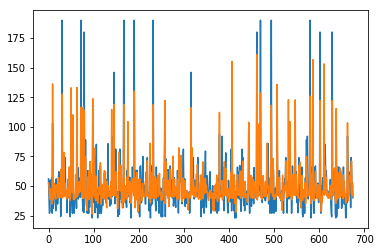

In [0]:
plt.plot(actual)
plt.plot(pred)



In [0]:
hidl = tf.add(tf.matmul(x,wh),bh, name ='hidden1')

In [19]:
outl_batch = tf.compat.v1.layers.batch_normalization(hidl)
outl = tf.add(tf.matmul(outl_batch,wo),bo,name = 'output')


W0730 04:55:38.402069 140609144244096 deprecation.py:323] From <ipython-input-19-692609249b69>:1: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,outl))) + 0.4*tf.reduce_max(tf.subtract(y,outl))
#default lr = 0.001
opt = tf.train.AdamOptimizer(name = 'optimizer')
op_train = opt.minimize(loss, name ='train_op')



In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

In [23]:
train=[]
val=[]

with tf.device('/device:CPU:0'):
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    mini =[]
    for i in range(0,2000):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
      #TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
      z= sess.run([loss,op_train, update_ops], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      
      ##VALIDATION LOSS
      
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    plt.plot(train)
    plt.plot(val)
    
    model = simple_save(sess,'/content/drive/My Drive/Custom_Models__withouttransmission/2000',inputs = {'input' : x}, outputs = {'output': outl})
    print('Saved model!')
    
 

ValueError: ignored

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_64updhidden.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())

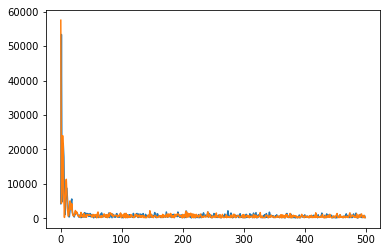

In [0]:
plt.plot(train[1:])
plt.plot(val[1:])

In [0]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(11, 18) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 18) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(18, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/gamma:0' shape=(18,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/beta:0' shape=(18,) dtype=float32_ref>]

In [0]:
## 48 BIT (2253,2315)
'''
features = joblib.load('/content/features48.pkl')
labels = joblib.load('/content/labels48.pkl')
'''

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''